# Timeseries Anomaly Detection using Keras Autoencoder
***

Project is based on Keras Timeseries anomaly detection using Autoenoder
https://keras.io/examples/timeseries/timeseries_anomaly_detection/
___

## Introduction

In [1]:
# Importing required packages Numpy for numerical multi-dimensional arrays
import numpy as np
# Dataframe operations
import pandas as pd
# Neural networks
import tensorflow.keras as keras
# Pyplot for plotting
import matplotlib.pyplot as plt

#### Note:
Machine configuration this project was prepared does not alow Keras model to be fitted and trained. Possibly due to resource allocation restrictions that is causing bottlenecking and crash of kernel.
After numerous trials GPU processing did not get enabled to perform this tasks an the only viable solution was to set environment variable KMP_DUPLICATE_LIB_OK=TRUE to allow the program to continue to execute. No issues encountered when running the code on Google Colab. Solution adapted from https://stackoverflow.com/a/64816968 with a possibility of silently produced incorrect results.

#### Console error message:
/* 2023-01-05 18:40:33.939491: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
OMP: Error #15: Initializing libiomp5, but found libiomp5md.dll already initialized.
OMP: Hint This means that multiple copies of the OpenMP runtime have been linked into the program. That is dangerous, since it can degrade performance or cause incorrect results. The best thing to do is to ensure that only a single OpenMP runtime is linked into the process, e.g. by avoiding static linking of the OpenMP runtime in any library. As an unsafe, unsupported, undocumented workaround you can set the environment variable KMP_DUPLICATE_LIB_OK=TRUE to allow the program to continue to execute, but that may cause crashes or silently produce incorrect results. For more information, please see http://openmp.llvm.org/ */

In [2]:
# Enabling environment variable as a workaround for kernel crash issue
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Data
___

Timeseries data used for Keras autoencoder anomaly detection is available on [Kaggle](https://www.kaggle.com/datasets/boltzmannbrain/nab). It is known as Numenta Anomaly Benchmark (NAB) and is commonly used for benchmarking and scoring algorithms for detecting anomalies in streaming data. Full information about the dataset is available on [Numenta GitHub](https://github.com/numenta/NAB) page. In this section data will be retrieved and reviewed in its original state.

In [3]:
# Root of URLs
root_url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/'

# Data file without anomaly
no_anomaly_url = root_url + 'artificialNoAnomaly/art_daily_small_noise.csv'

# Data file with anomaly
with_anomaly_url = root_url + 'artificialWithAnomaly/art_daily_jumpsup.csv'

In [4]:
# Panda CSV read is used to retrieve no-anomaly data as df_small_noise
df_small_noise = pd.read_csv(no_anomaly_url, parse_dates=True, index_col="timestamp")

In [5]:
# Looking at top 5 entires to see data format
df_small_noise.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


In [6]:
# Reviewing descriptive statistics of no-anomaly df
df_small_noise.describe()

,value
count,4032.000000
mean,42.438353
std,28.077122
min,18.000964
25%,19.841390
50%,21.608487
75%,75.450282
max,87.976128


In [7]:
# Looking at zero index row
df_small_noise.iloc[0]

value    18.324919
Name: 2014-04-01 00:00:00, dtype: float64

In [8]:
# Extracting zero index row value under 'value' field
df_small_noise.iloc[0]['value']

18.3249185392

In [9]:
# Same as above only specifying exact value to be returned
df_small_noise.iloc[0].values[0]

18.3249185392

In [10]:
# Checking dataset shape
df_small_noise.shape

(4032, 1)

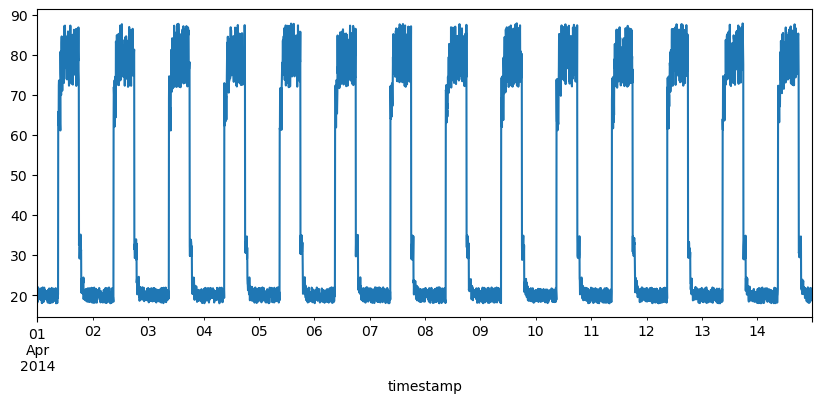

In [11]:
# Setting plot figure axes size
fig, ax = plt.subplots(figsize=(10,4))

# Using pandas to plot data frame
df_small_noise.plot(legend=False, ax=ax);

In [12]:
# Panda CSV read is used to retrieve anomaly data as df_daily_jumpsup
df_daily_jumpsup = pd.read_csv(with_anomaly_url, parse_dates=True, index_col="timestamp")

In [13]:
# Looking at top 5 entires to see data format
df_daily_jumpsup.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


In [14]:
# Reviewing descriptive statistics for anomaly df
df_daily_jumpsup.describe()

,value
count,4032.000000
mean,44.494254
std,32.432473
min,18.001010
25%,19.991382
50%,21.648503
75%,76.435943
max,164.947481


In [15]:
# Extracting zero index row value under 'value' field
df_daily_jumpsup.iloc[0]['value']

19.761251903

In [16]:
# Checking dataset shape
df_daily_jumpsup.shape

(4032, 1)

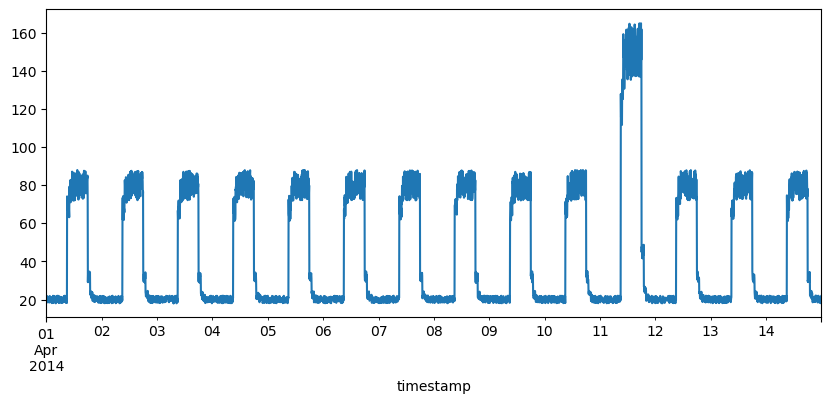

In [17]:
# Setting plot figure axes size
fig, ax = plt.subplots(figsize=(10,4))

# Using pandas to plot data frame.
df_daily_jumpsup.plot(legend=False, ax=ax);

## Preprocessing
___

Once dataset is retrieved and loaded for manipulation the next step is to prepare data for processing. It involves:
- Data Profiling- reviewing data and its statistics to determine if it matches suitability requirements like observation count and  missing data;
- Data Cleaning- removing missing data fields and NAN values;
- Data Reduction- removing non relevant data to enhance processing speed and reduce errors;
- Data Transformation- arranging data in specific format depending on processing language requirements;
- Data Enrichment- combining primary data with that retrieved from additional sources;
- Data Validation- dataset splitting into training and test subsets for verification of model efficiency and accuracy. 





In [18]:
# Recording and returning no-anomaly df mean value
train_mean = df_small_noise.mean()
train_mean

value    42.438353
dtype: float64

In [19]:
# Recording and returning no-anomaly standard deviation value
train_std = df_small_noise.std()
train_std

value    28.077122
dtype: float64

In [20]:
# Z-Score normalization for train values
# Normalizing values so the mean is 0 and std deviation is 1
df_train_vals = (df_small_noise - train_mean) / train_std

In [21]:
# Top 5 train data values
df_train_vals.head()

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173


In [22]:
# Calculating and appending df with mean and standard deviation of each value
df_small_noise['less_mean'] = df_small_noise['value'] - df_small_noise['value'].mean()
df_small_noise['div_std'] = df_small_noise['less_mean'] / df_small_noise['value'].std()

In [23]:
# Top 5 data values
df_small_noise.head()

,value,less_mean,div_std
timestamp,,,
2014-04-01 00:00:00,18.324919,-24.113435,-0.858829
2014-04-01 00:05:00,21.970327,-20.468026,-0.728993
2014-04-01 00:10:00,18.624806,-23.813547,-0.848148
2014-04-01 00:15:00,21.953684,-20.484669,-0.729586
2014-04-01 00:20:00,21.909120,-20.529234,-0.731173


In [24]:
# Calculating mean of each column
df_small_noise['value'].mean(), df_small_noise['less_mean'].mean(), df_small_noise['div_std'].mean()

(42.438353335806646, -7.342627387941552e-14, -2.616541242931684e-15)

In [25]:
# Calculating standard deviation of each column
df_small_noise['value'].std(), df_small_noise['less_mean'].std(), df_small_noise['div_std'].std()

(28.077122281262515, 28.077122281262508, 1.0000000000000018)

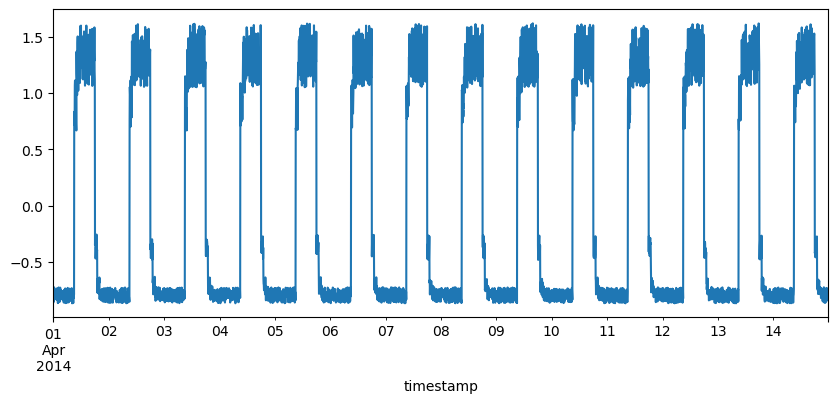

In [26]:
# Setting plot figure axes size
fig, ax = plt.subplots(figsize=(10,4))

# Use pandas to plot normalized data
df_train_vals.plot(legend=False, ax=ax);

In [27]:
# Checking dataset shape
df_train_vals.shape

(4032, 1)

To normalize training data window values are calculated. Dataset has observation every 5 minutes for 14 days hence daily sample is: **24 * 60 / 5 = 288**<br>
Total observations recorded are: **288 * 14 = 288**

In [28]:
# Daily observations
window_size = 288

In [29]:
# Window list example
L = [1, 1, 2, 4, 5, 6, 7, 1, 2, 3, 4, 5]
# Example window size
win_size = 3
# Length of L
len(L)

12

In [30]:
# Number of windows from L
len(L) - (win_size - 1)

10

In [31]:
# Remove brackets
len(L) - win_size + 1

10

In [32]:
# Print the windows
for i in range(len(L) - win_size + 1):
    print(L[i:i + win_size])

[1, 1, 2]
[1, 2, 4]
[2, 4, 5]
[4, 5, 6]
[5, 6, 7]
[6, 7, 1]
[7, 1, 2]
[1, 2, 3]
[2, 3, 4]
[3, 4, 5]


In [33]:
# Array for accumulation of windows
wins = []

# Generating windows
for i in range(len(L) - win_size + 1):
    wins.append(L[i:i + win_size])

wins

[[1, 1, 2],
 [1, 2, 4],
 [2, 4, 5],
 [4, 5, 6],
 [5, 6, 7],
 [6, 7, 1],
 [7, 1, 2],
 [1, 2, 3],
 [2, 3, 4],
 [3, 4, 5]]

In [34]:
# Creating a 2D numpy array from wins
np.stack(wins)

array([[1, 1, 2],
       [1, 2, 4],
       [2, 4, 5],
       [4, 5, 6],
       [5, 6, 7],
       [6, 7, 1],
       [7, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 5]])

In [35]:
# Function example to generate training sequences
def windows(vals, N=window_size):
  # Array for accumulation of windows
  L = []
  # For loop for iteration across each value 
  for i in range(len(vals) - N + 1):
    # Append result to a list 
    L.append(vals[i:i+N])
  # Stack into 2D array
  return np.stack(L)

In [36]:
# Dividing training data into windows
x_train = windows(df_train_vals)

In [37]:
# Checking first an last value
x_train[0][0], x_train[-1][-1]

(array([-0.85882857]), array([-0.8460886]))

In [38]:
# Extracting zero index and last rows
df_train_vals.iloc[0], df_train_vals.iloc[-1]

(value   -0.858829
 Name: 2014-04-01 00:00:00, dtype: float64,
 value   -0.846089
 Name: 2014-04-14 23:55:00, dtype: float64)

In [39]:
# Checking training subset shape
x_train.shape

(3745, 288, 1)

In [40]:
# Checking values of 'value' column
df_train_vals['value'].values

array([-0.85882857, -0.72899302, -0.84814772, ..., -0.83364049,
       -0.73510213, -0.8460886 ])

In [41]:
# Returns one dimensional array
x_train[0].flatten();

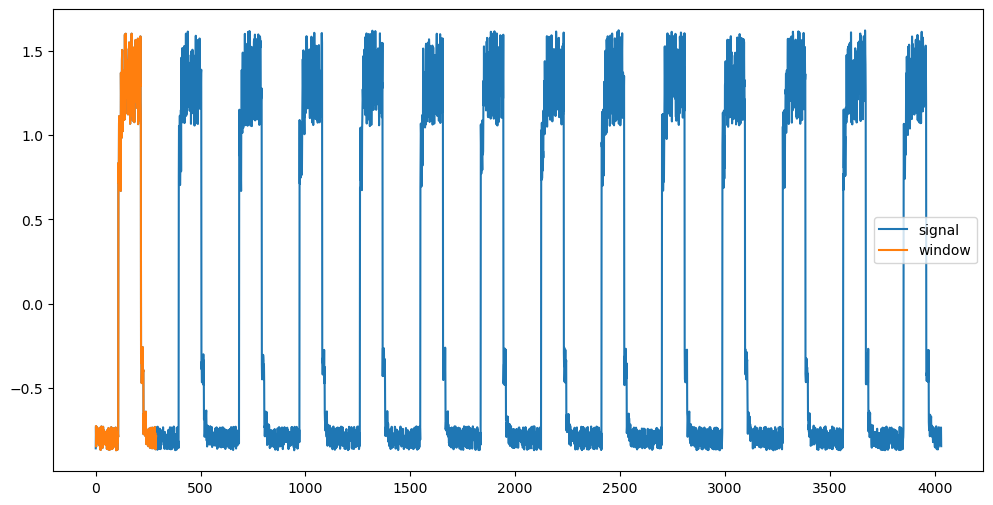

In [42]:
# Selecting window by number
window_no = 1

# Setting plot figure axes size
fig, ax = plt.subplots(figsize=(12, 6))

# Assigning training set value as Y
y = df_train_vals['value'].values

# Plotting Y values
ax.plot(np.arange(y.shape[0]), y, label='signal')

# The first window
w = x_train[window_no].flatten()

# Plotting window 1 values only
ax.plot(np.arange(w.shape[0]) + window_no, w, label='window')

ax.legend();

### Neural Network
___

Machine learning looks at methods how computers can interpret data by applying different algorithms and make decisions based on the result. Underlying idea implies that machine can learn from data provided based on patterns recorded that can be used in further decision making. Some of the applications of machine learning includes: speech and image recognition, time series anomaly detection, natural language processing, predictive analytics. Machine learning is commonly separated into subtypes like supervised, unsupervised and reinforcement learning:

- Supervised learning requires model to be trained on labeled data with desired outcome identified.
- Unsupervised learning is based on unlabeled data where model analyses patterns and relationships of input data points.
- Reinforcement learning involves model training on trial and error approach where historic outcomes are considered for future decision making.

As solutions to each problem is not programmed it is up to algorithm to derive a solution. There are multiple architectures of Artificial Neural Networks that takes different approach to solve a problem: Recurrent Neural Network, Single Layer Perceptron, Multi Layer Perceptron, Radial Basis Network, Long short-term memory(LSTM) to name a few. This project looks at Autoencoder a type of Neural Network architectures hence we will delve deeper into it.

Autoencoder consist of the following layers:
- Input: Data being analyzed.
- Encoder: Takes high dimensional data and maps it to lower dimensional data through the process of compression.
- Bottleneck: Optimization model code that once completed with learning phase will be used for anomaly detection.
- Decoder: Takes encoded data and decodes it mapping it back to original dimensions through reconstruction.
- Output also known as Reconstructed Input:

Each layers consists of multiple nodes (neurons) within each layer that takes input, breaks it down to components and performs a calculation that is being sent to next neuron forming a chain that passes all layers. At each stage result is getting approximated through iterative optimization process minimizing error value. Each neuron layer is a function of functions forming a network. Autoencoder has output set as its input was encoding a dense input data representation.

Neuron visualization:

![Neuron](graph/neuron2.svg)

Each neuron also known as vector or tensor is looking to solve a function where input x1 and output phi, that also can be denoted as y is known, but weight w1 and bias w0 is not. 

$$ \phi (w_1x_1 + w_0(1)) = w_1x_1 + w_0$$

Simplified version where w1 weight and w0 bias is m and c respectively:
$$ y = mx + c $$

Iterative adjustments are made at each pass to get closer to expected values that will fulfill function requirements to match expected values. Value optimization continues within the model layers finding the model that can reconstruct original input at lowest reconstruction error(loss).
___

Keras model [layers](https://keras.io/api/layers/) used in this project:
    
- Core/Activation: Applies activation function on the output
- Convolution/Conv1D/Conv1DTranspose: The main block of the model that applies filters (kernels) to an input in order to summarize parameters and features detected in model training.
- Regularization/Dropout: Randomly sets at set frequency to prevent overfitting. Without it all layer neurons will synchronously optimize their weights. 

In [43]:
# Defining layers for Autoencoder model:
layers = [
  # Activation: Setting up layers and data input shape
  keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
  # Convolution layer
  keras.layers.Conv1D(
    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
  # Dropout layer
  keras.layers.Dropout(rate=0.2),
  # Convolution layer
  keras.layers.Conv1D(
    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
   # Convolution layer
  keras.layers.Conv1DTranspose(
    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
  # Dropout layer
  keras.layers.Dropout(rate=0.2),
   # Convolution layer
  keras.layers.Conv1DTranspose(
    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
   # Convolution layer
  keras.layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
]

In [44]:
# Creating model based on layers setup
model = keras.Sequential(layers)

[Model](https://keras.io/api/models/model/)- groups layers into an object with training and inference features.

[Sequential](https://keras.io/api/models/sequential/)- groups a linear stack of layers into a tf.keras.Model and provides training and inference features on this model.

In [45]:
# Setting Adam optimizer with learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.001)

[Optimizer](https://keras.io/api/optimizers/) function implements specified algorithm used to minimize the function while compiling the model.

In [46]:
# Compiling model
model.compile(optimizer=optimizer, loss="mse")

In [47]:
# Outputting model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                              

In [48]:
# Fitting the model
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 2s 50ms/step - loss: 0.5020 - val_loss: 0.0732
Epoch 2/50
27/27 [==============================] - 1s 43ms/step - loss: 0.0832 - val_loss: 0.0431
Epoch 3/50
27/27 [==============================] - 1s 42ms/step - loss: 0.0626 - val_loss: 0.0391
Epoch 4/50
27/27 [==============================] - 1s 42ms/step - loss: 0.0538 - val_loss: 0.0336
Epoch 5/50
27/27 [==============================] - 1s 42ms/step - loss: 0.0470 - val_loss: 0.0299
Epoch 6/50
27/27 [==============================] - 1s 44ms/step - loss: 0.0414 - val_loss: 0.0262
Epoch 7/50
27/27 [==============================] - 1s 43ms/step - loss: 0.0372 - val_loss: 0.0240
Epoch 8/50
27/27 [==============================] - 1s 45ms/step - loss: 0.0338 - val_loss: 0.0228
Epoch 9/50
27/27 [==============================] - 1s 42ms/step - loss: 0.0312 - val_loss: 0.0214
Epoch 10/50
27/27 [==============================] - 1s 41ms/step - loss: 0.0290 - val_loss: 0.0206
Epoch 11/

### Evaluation
___

In [49]:
history.history["loss"];

In [50]:
history.history["val_loss"];

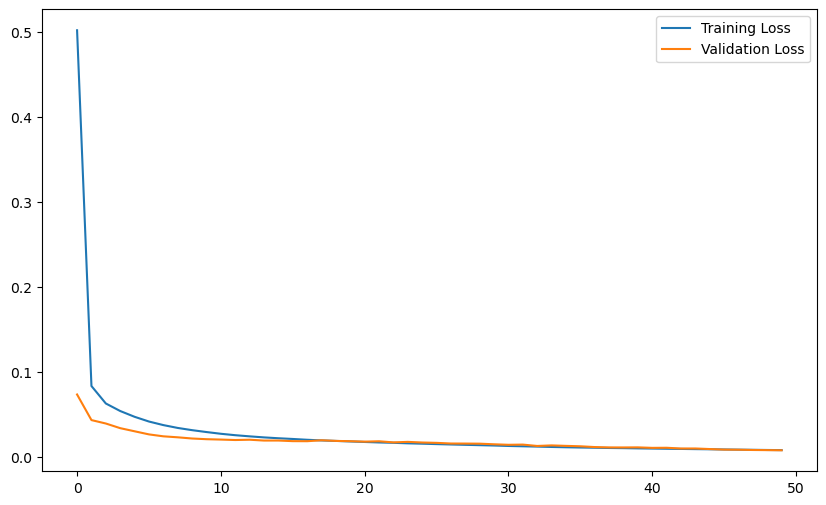

In [51]:
# Setting plot figure axes size
fig, ax = plt.subplots(figsize=(10, 6))
# Plotting data line for training loss
ax.plot(history.history["loss"], label="Training Loss")
# Plotting data line for validation Loss
ax.plot(history.history["val_loss"], label="Validation Loss")
# Including plot legend
ax.legend();

In [52]:
# Getting training data MAE loss
x_train_pred = model.predict(x_train)

118/118 [==============================] - 1s 4ms/step


In [53]:
# Calculating loss
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

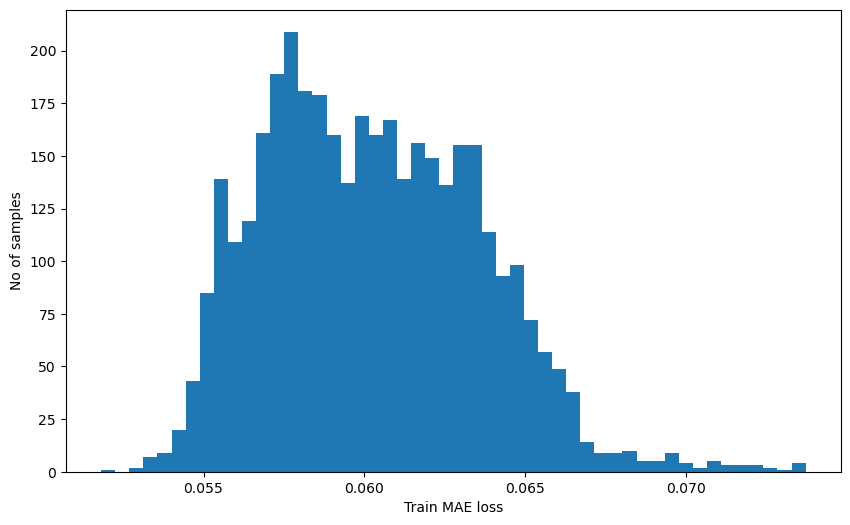

In [54]:
# Setting plot figure axes size
fig, ax = plt.subplots(figsize=(10, 6))
# Histogram of MAE loss
ax.hist(train_mae_loss, bins=50)
# x axis label
ax.set_xlabel("Train MAE loss")
# y axis label
ax.set_ylabel("No of samples");

In [55]:
# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)

# Output threshold value
threshold

0.07371098884810752

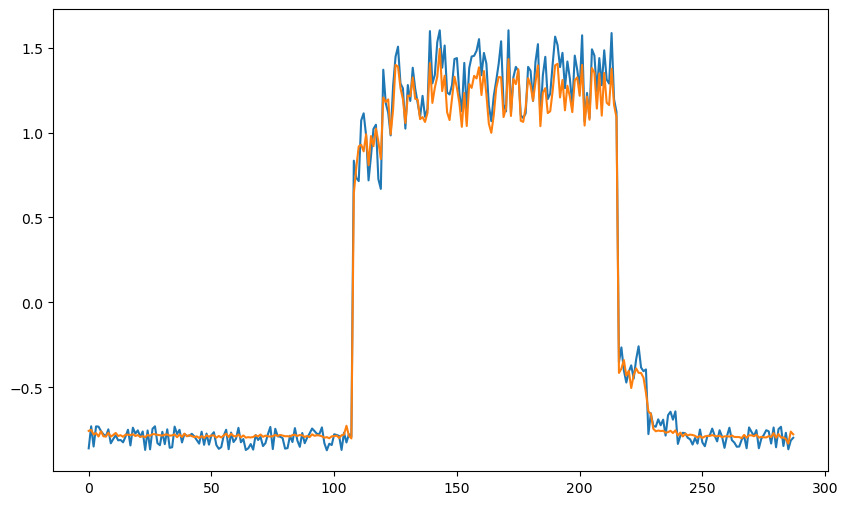

In [56]:
# Setting plot figure axes size
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting actual values
ax.plot(x_train[0])

# Plotting predicted values
ax.plot(x_train_pred[0]);

In [57]:
# Z-Score normalization for test values
df_test_value = (df_daily_jumpsup - train_mean) / train_std

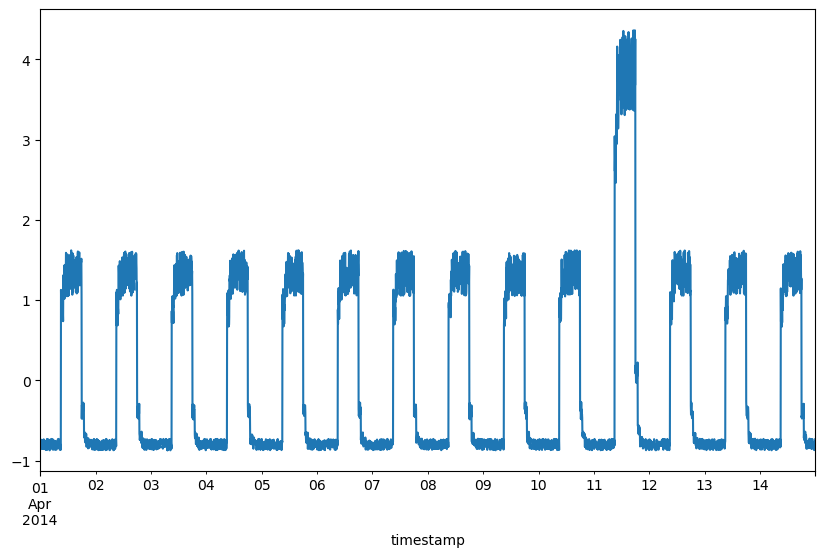

In [58]:
# Setting plot figure axes size
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting dataset with anomaly
df_test_value.plot(legend=False, ax=ax);

In [59]:
# Creating sequences from test values
x_test = windows(df_test_value.values)

# Output data value
x_test.shape

(3745, 288, 1)

In [60]:
# Running prediction model
x_test_pred = model.predict(x_test)

118/118 [==============================] - 1s 5ms/step


In [61]:
# Calculating loss
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

# Show loss values
test_mae_loss

array([[0.06019863],
       [0.05991619],
       [0.06037015],
       ...,
       [0.0630492 ],
       [0.06418699],
       [0.06328068]])

In [62]:
# Reshaping results to 1d array
test_mae_loss = test_mae_loss.reshape((-1))

# Show loss values
test_mae_loss

array([0.06019863, 0.05991619, 0.06037015, ..., 0.0630492 , 0.06418699,
       0.06328068])

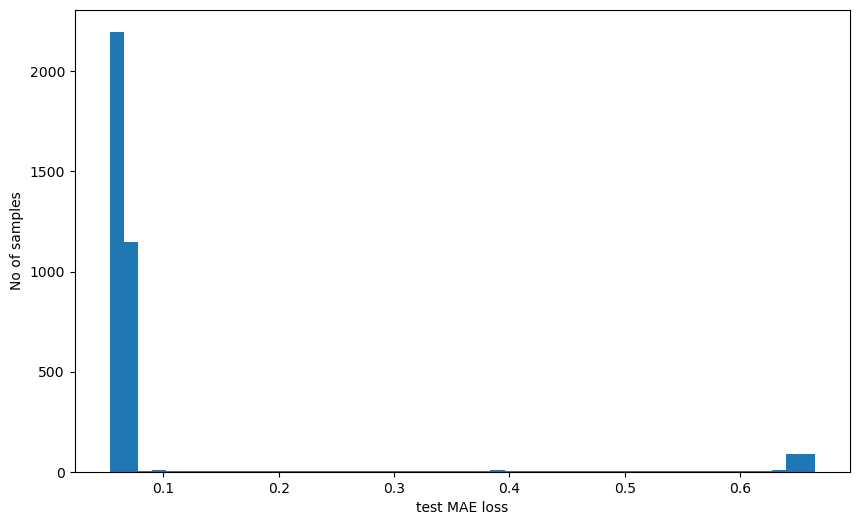

In [63]:
# Setting plot figure axes size
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting loss values
ax.hist(test_mae_loss, bins=50)

# x axis label
ax.set_xlabel("test MAE loss")

# y axis label
ax.set_ylabel("No of samples");

In [64]:
# Detect all the samples which are anomalies
anomalies = test_mae_loss > threshold

# Number of anomalies
np.sum(anomalies)

434

In [65]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
inds = []

for i in range(window_size - 1, len(df_test_value) - window_size + 1):
    if np.all(anomalies[i - window_size + 1 : i]):
        inds.append(i)

In [66]:
# Creating data subset to highlight windows that has anomaly
df_subset = df_daily_jumpsup.iloc[inds]

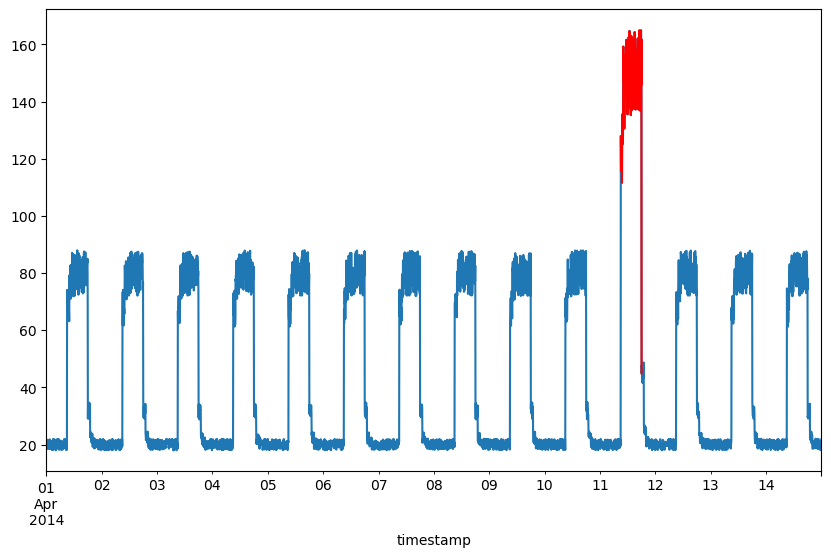

In [67]:
# Setting plot figure axes size
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting anomaly dataset
df_daily_jumpsup.plot(legend=False, ax=ax)

# Plotting anumaly observations on top to highlight them in red
df_subset.plot(legend=False, ax=ax, color="r");

Identifying unusual data patterns is the main aim of this Keras Autoencoder model. After training the model with consistent data and trying prediction for anomaly result is visible in the plot above clearly identifying anomaly within the dataset.

### Conclusion:
For further exploration it is suggested to delve deeper into model parameters adjusting layers and loss function parameters confirming how each change is affecting model results. Also, using different optimizer algorithms.

References:<br>

https://keras.io/api/<br>
https://github.com/ianmcloughlin/2223-S1-machine-learn-stats<br>
https://www.techtarget.com/searchdatamanagement/definition/data-preprocessing<br>
https://www.geeksforgeeks.org/data-preprocessing-in-data-mining/<br>
https://www.statology.org/z-score-normalization/<br>
https://towardsdatascience.com/anomaly-detection-using-autoencoders-5b032178a1ea<br>
https://medium.com/analytics-vidhya/anomaly-detection-in-cardio-dataset-using-deep-learning-technique-autoencoder-fd24ca9e5c69<br>
https://www.analyticsvidhya.com/blog/2022/01/complete-guide-to-anomaly-detection-with-autoencoders-using-tensorflow/<br>
https://towardsdatascience.com/anomaly-detection-with-autoencoder-b4cdce4866a6<br>
https://medium.com/chingu/neuron-explained-using-simple-algebra-example-b18f5e280845<br>
https://angela-wong.medium.com/rmse-or-mae-which-and-why-loss-functions-used-in-regression-and-classification-a98afc9fa215<br>
https://towardsdatascience.com/understanding-the-3-most-common-loss-functions-for-machine-learning-regression-23e0ef3e14d3<br>
https://www.markdownguide.org/extended-syntax<br>



___

## The End.